# Homicide Dataset Feature Selection

This notebook analyzes a homicide dataset to identify the 15 most important features using multiple feature selection methods.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
# Update the path if needed
df = pd.read_csv('SHR65_23.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Display column information
print("\nDataset columns:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

Dataset shape: (894636, 30)

First 5 rows:


,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,197603001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,March,...,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
1,197604001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,April,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Girlfriend,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
2,197606001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,June,...,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Other,NaN,0,0,30180.0,"Anchorage, AK"
3,197606002AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,June,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Other - known to victim,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"
4,197607001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,July,...,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Anchorage, AK"



Dataset columns:
1. ID
2. CNTYFIPS
3. Ori
4. State
5. Agency
6. Agentype
7. Source
8. Solved
9. Year
10. Month
11. Incident
12. ActionType
13. Homicide
14. Situation
15. VicAge
16. VicSex
17. VicRace
18. VicEthnic
19. OffAge
20. OffSex
21. OffRace
22. OffEthnic
23. Weapon
24. Relationship
25. Circumstance
26. Subcircum
27. VicCount
28. OffCount
29. FileDate
30. MSA


## 3. Data Preprocessing

In [3]:
def preprocess_data(data):
    # Make a copy to avoid modifying the original data
    df_processed = data.copy()
    
    # Check for missing values
    print("\nMissing values before preprocessing:")
    display(df_processed.isna().sum())
    
    # Handle missing values
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object':
            df_processed[col].fillna('Unknown', inplace=True)
        else:
            df_processed[col].fillna(0, inplace=True)
    
    # Convert categorical variables to numerical using Label Encoding
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    print(f"\nCategorical columns to encode: {len(categorical_cols)}")
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
    
    print("\nData types after encoding:")
    display(df_processed.dtypes)
    
    return df_processed, label_encoders

# Process the data
processed_data, encoders = preprocess_data(df)


Missing values before preprocessing:


ID                   0
CNTYFIPS             0
Ori                  0
State                0
Agency               0
Agentype             0
Source               0
Solved               0
Year                 0
Month                0
Incident             0
ActionType           0
Homicide             0
Situation            0
VicAge               0
VicSex               0
VicRace              0
VicEthnic            0
OffAge               0
OffSex               0
OffRace              0
OffEthnic            0
Weapon               0
Relationship         0
Circumstance         0
Subcircum       859886
VicCount             0
OffCount             0
FileDate         17075
MSA                  0
dtype: int64


Categorical columns to encode: 23

Data types after encoding:


ID                int32
CNTYFIPS          int32
Ori               int32
State             int32
Agency            int32
Agentype          int32
Source            int32
Solved            int32
Year              int64
Month             int32
Incident          int64
ActionType        int32
Homicide          int32
Situation         int32
VicAge            int64
VicSex            int32
VicRace           int32
VicEthnic         int32
OffAge            int64
OffSex            int32
OffRace           int32
OffEthnic         int32
Weapon            int32
Relationship      int32
Circumstance      int32
Subcircum         int32
VicCount          int64
OffCount          int64
FileDate        float64
MSA               int32
dtype: object

## 4. Feature Importance Methods

### 4.1 Random Forest Feature Importance

Using 'Solved' as target variable for Random Forest feature importance
Random Forest model accuracy: 0.9996


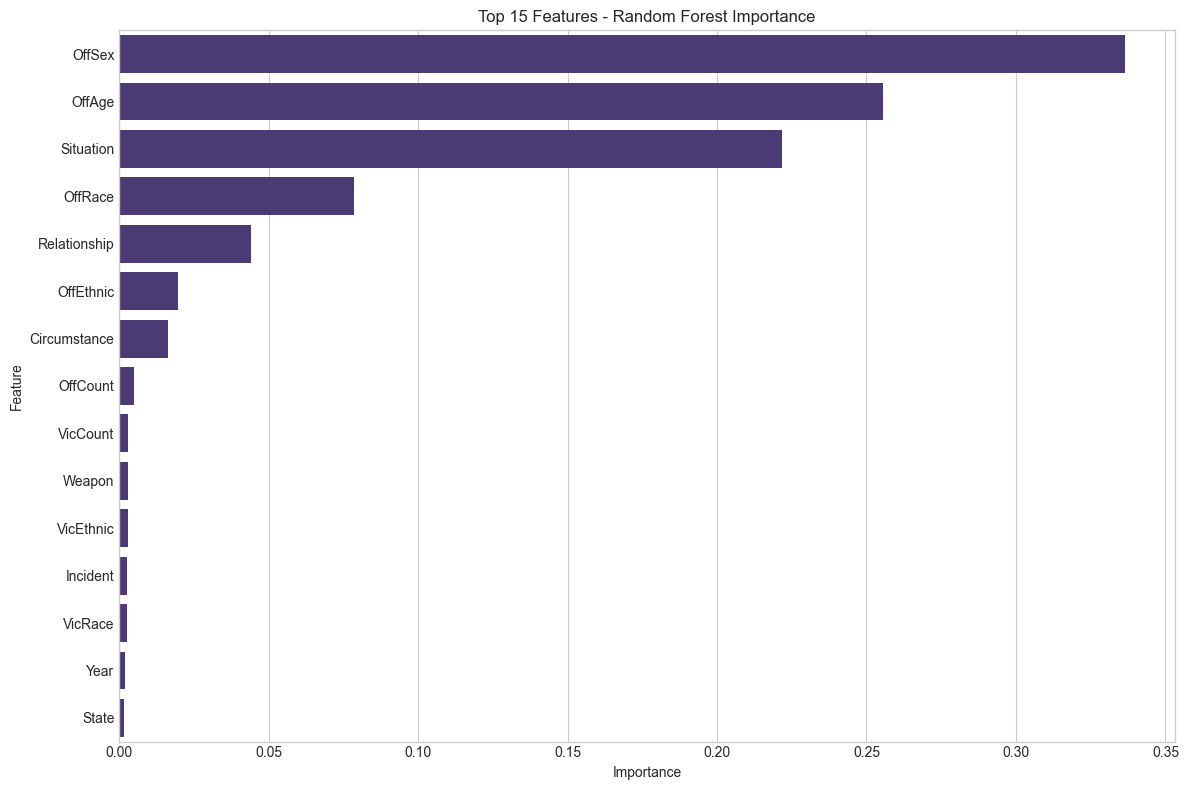

In [4]:
def random_forest_importance(data, target_col='Solved', n_features=15):
    # For this example, we'll use 'Solved' as the target variable
    # You can change this to another column depending on what you want to predict
    print(f"Using '{target_col}' as target variable for Random Forest feature importance")
    
    # Prepare the data
    features_to_drop = ['ID']
    if 'CNTYFIPS' in data.columns:
        features_to_drop.append('CNTYFIPS')
    if 'Ori' in data.columns:
        features_to_drop.append('Ori')
        
    X = data.drop(columns=[target_col] + features_to_drop, errors='ignore')
    y = data[target_col]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate model accuracy
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest model accuracy: {accuracy:.4f}")
    
    # Get feature importances
    importances = rf.feature_importances_
    
    # Create a DataFrame to store feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(n_features))
    plt.title(f'Top {n_features} Features - Random Forest Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

rf_importance = random_forest_importance(processed_data, n_features=15)

### 4.2 Gradient Boosting Feature Importance

Using 'Solved' as target variable for Gradient Boosting feature importance
Gradient Boosting model accuracy: 0.9995


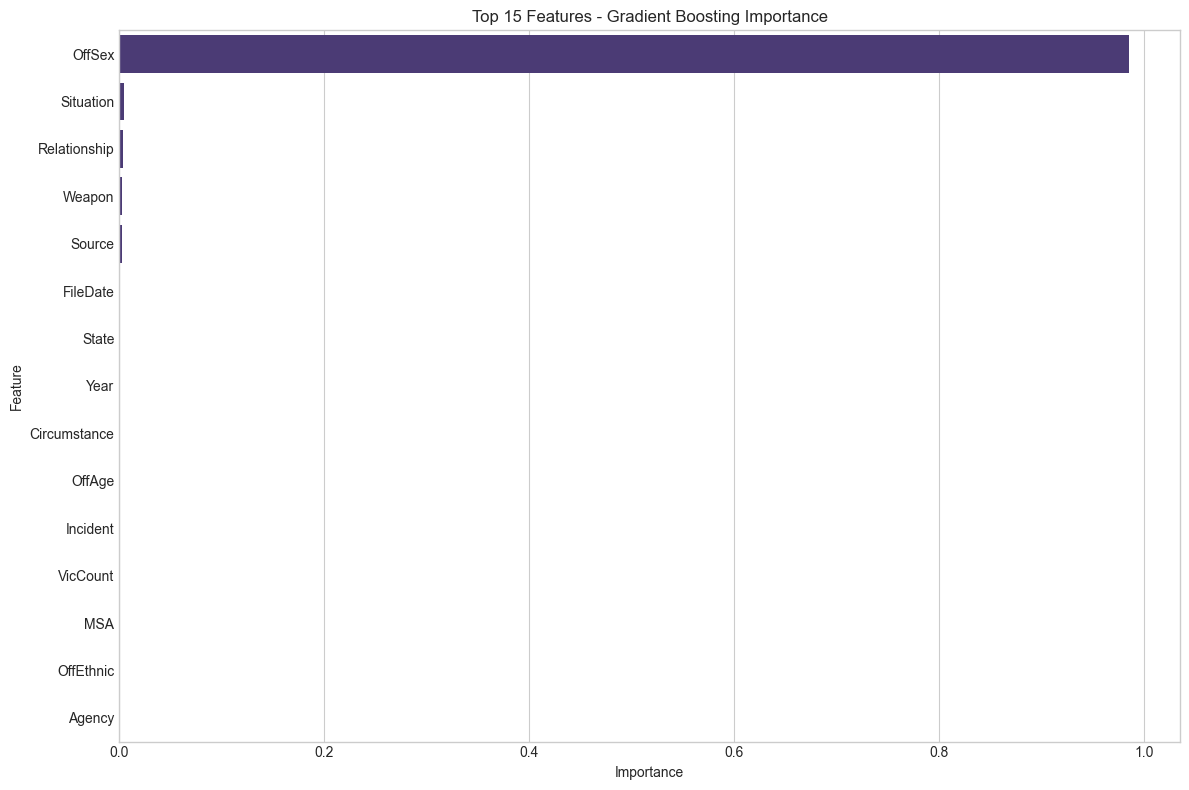

In [5]:
def gradient_boosting_importance(data, target_col='Solved', n_features=15):
    print(f"Using '{target_col}' as target variable for Gradient Boosting feature importance")
    
    # Prepare the data
    features_to_drop = ['ID']
    if 'CNTYFIPS' in data.columns:
        features_to_drop.append('CNTYFIPS')
    if 'Ori' in data.columns:
        features_to_drop.append('Ori')
        
    X = data.drop(columns=[target_col] + features_to_drop, errors='ignore')
    y = data[target_col]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a Gradient Boosting model
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    
    # Evaluate model accuracy
    y_pred = gb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Gradient Boosting model accuracy: {accuracy:.4f}")
    
    # Get feature importances
    importances = gb.feature_importances_
    
    # Create a DataFrame to store feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(n_features))
    plt.title(f'Top {n_features} Features - Gradient Boosting Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

gb_importance = gradient_boosting_importance(processed_data, n_features=15)

### 4.3 Mutual Information Feature Importance

Using 'Solved' as target variable for Mutual Information feature importance


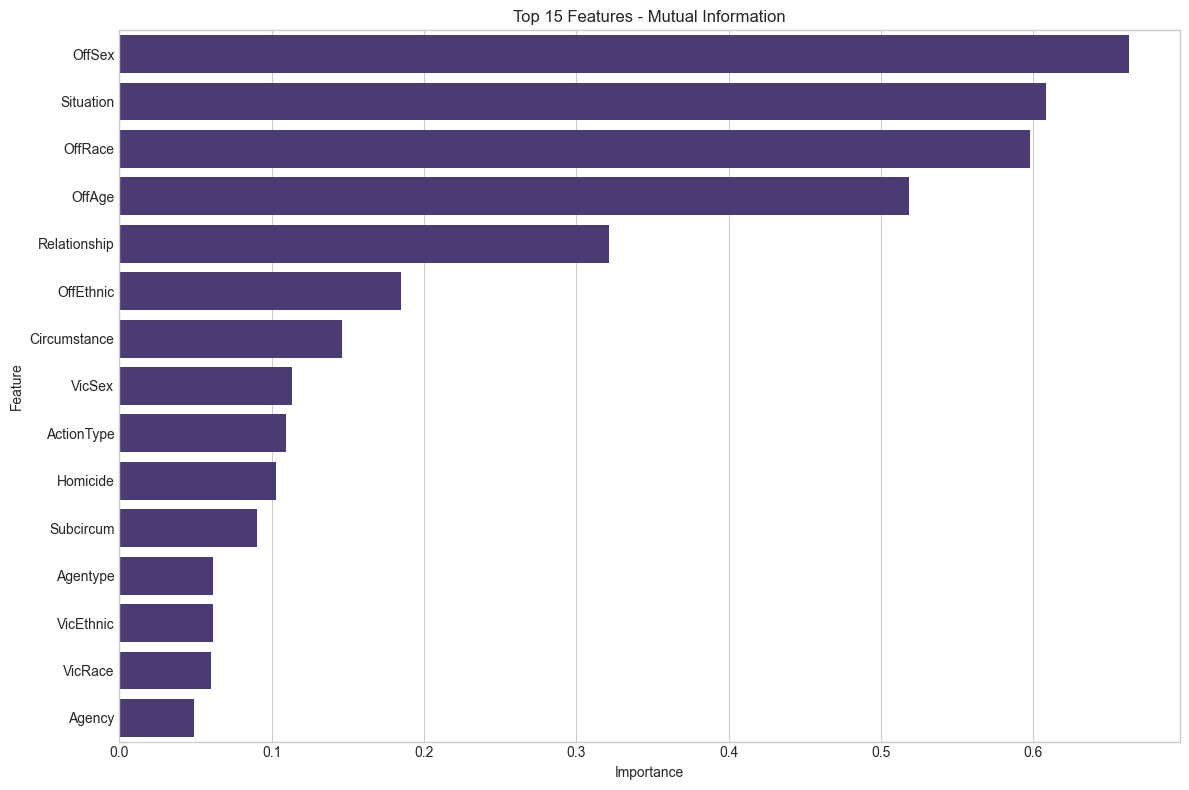

In [6]:
def mutual_info_importance(data, target_col='Solved', n_features=15):
    print(f"Using '{target_col}' as target variable for Mutual Information feature importance")
    
    # Prepare the data
    features_to_drop = ['ID']
    if 'CNTYFIPS' in data.columns:
        features_to_drop.append('CNTYFIPS')
    if 'Ori' in data.columns:
        features_to_drop.append('Ori')
        
    X = data.drop(columns=[target_col] + features_to_drop, errors='ignore')
    y = data[target_col]
    
    # Calculate mutual information
    mi = mutual_info_classif(X, y, random_state=42)
    
    # Create a DataFrame to store feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': mi
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(n_features))
    plt.title(f'Top {n_features} Features - Mutual Information')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

mi_importance = mutual_info_importance(processed_data, n_features=15)

## 5. Combine Feature Importance Results

In [7]:
def combined_feature_importance(rf_importance, gb_importance, mi_importance, n_features=15):
    # Normalize each importance score
    for df in [rf_importance, gb_importance, mi_importance]:
        max_val = df['Importance'].max()
        df['Normalized_Importance'] = df['Importance'] / max_val
    
    # Combine the results
    combined = pd.DataFrame()
    combined['Feature'] = rf_importance['Feature']
    
    # Add normalized scores
    combined['RF_Score'] = rf_importance['Normalized_Importance'].values
    combined['GB_Score'] = pd.Series(dtype='float64')
    combined['MI_Score'] = pd.Series(dtype='float64')
    
    # Match features and add scores
    for idx, feature in enumerate(combined['Feature']):
        gb_idx = gb_importance[gb_importance['Feature'] == feature].index
        mi_idx = mi_importance[mi_importance['Feature'] == feature].index
        
        if len(gb_idx) > 0:
            combined.at[idx, 'GB_Score'] = gb_importance.loc[gb_idx, 'Normalized_Importance'].values[0]
        
        if len(mi_idx) > 0:
            combined.at[idx, 'MI_Score'] = mi_importance.loc[mi_idx, 'Normalized_Importance'].values[0]
    
    # Calculate average score
    combined['Average_Score'] = combined[['RF_Score', 'GB_Score', 'MI_Score']].mean(axis=1)
    
    # Assign impact levels
    def assign_impact(score):
        if score >= 0.8:
            return "High Impact"
        elif score >= 0.5:
            return "Medium-High Impact"
        elif score >= 0.3:
            return "Medium Impact"
        elif score >= 0.1:
            return "Low-Medium Impact"
        else:
            return "Low Impact"
    
    combined['Impact_Level'] = combined['Average_Score'].apply(assign_impact)
    
    # Sort by average score
    combined = combined.sort_values('Average_Score', ascending=False)
    
    return combined

# Combine all methods
combined_importance = combined_feature_importance(rf_importance, gb_importance, mi_importance)

## 6. Visualize Top 15 Features

Top 15 Most Important Features:


,Feature,RF_Score,GB_Score,MI_Score,Average_Score,Impact_Level
0,State,0.004623,1.000000e+00,1.000000,0.668208,Medium-High Impact
15,OffSex,1.000000,2.575706e-03,0.000322,0.334299,Medium Impact
2,Agentype,0.002056,4.197027e-03,0.917820,0.308024,Medium Impact
3,Source,0.004511,8.528931e-07,0.901918,0.302143,Medium Impact
14,OffAge,0.759723,4.810192e-04,0.041023,0.267076,Low-Medium Impact
1,Agency,0.001368,1.452592e-05,0.781495,0.260959,Low-Medium Impact
9,Situation,0.658994,2.915190e-03,0.064555,0.242155,Low-Medium Impact
4,Year,0.005791,3.337948e-03,0.484913,0.164681,Low-Medium Impact
5,Month,0.000557,6.167281e-06,0.278702,0.093088,Low Impact
16,OffRace,0.233900,6.889675e-04,0.034645,0.089745,Low Impact


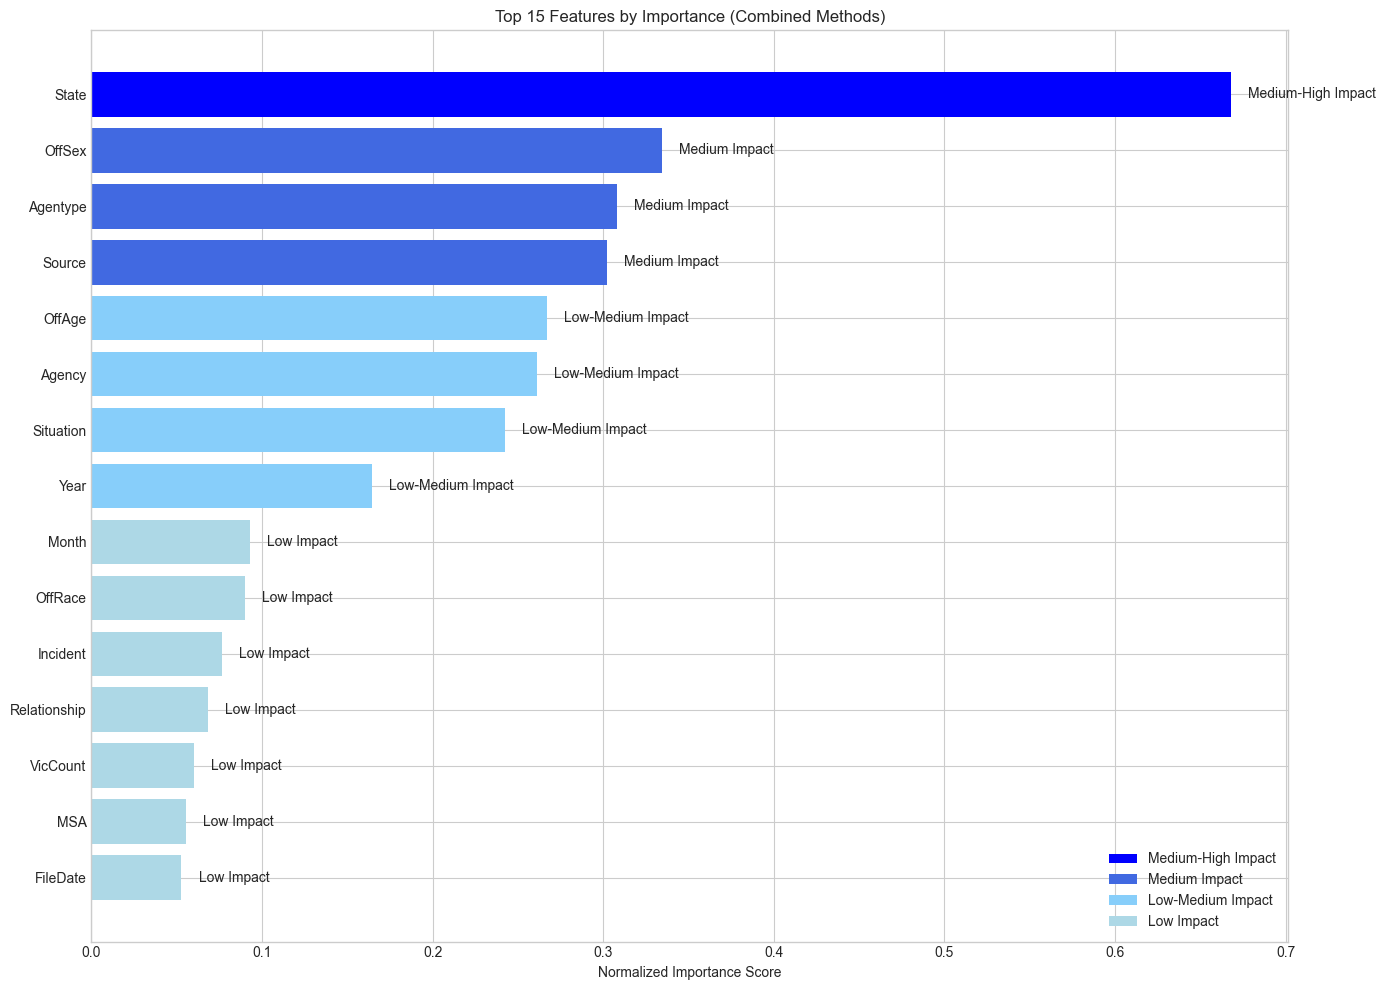

In [8]:
# Display top 15 features with their importance scores
top_features = combined_importance.head(15)
print("Top 15 Most Important Features:")
display(top_features[['Feature', 'RF_Score', 'GB_Score', 'MI_Score', 'Average_Score', 'Impact_Level']])

# Create a colormap based on impact levels
impact_colors = {'High Impact': 'darkblue',
                'Medium-High Impact': 'blue',
                'Medium Impact': 'royalblue',
                'Low-Medium Impact': 'lightskyblue',
                'Low Impact': 'lightblue'}

# Map impact levels to colors
bar_colors = [impact_colors[impact] for impact in top_features['Impact_Level']]

# Plot the combined feature importance scores
plt.figure(figsize=(14, 10))
bars = plt.barh(top_features['Feature'], top_features['Average_Score'], color=bar_colors)

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=impact) 
                   for impact, color in impact_colors.items() 
                   if impact in top_features['Impact_Level'].values]
plt.legend(handles=legend_elements, loc='lower right')

# Add impact level as text
for i, (feature, score) in enumerate(zip(top_features['Feature'], top_features['Average_Score'])):
    impact = top_features.iloc[i]['Impact_Level']
    plt.text(score + 0.01, i, impact, va='center')

plt.title('Top 15 Features by Importance (Combined Methods)')
plt.xlabel('Normalized Importance Score')
plt.gca().invert_yaxis()  # To match DataFrame order
plt.tight_layout()
plt.savefig('top15_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Compare Feature Ranking Methods

In [9]:
# Create a comparison table
def create_comparison_table(rf_imp, gb_imp, mi_imp, n_features=15):
    comparison = pd.DataFrame({
        'Random Forest': rf_imp.head(n_features)['Feature'].values,
        'Gradient Boosting': gb_imp.head(n_features)['Feature'].values,
        'Mutual Information': mi_imp.head(n_features)['Feature'].values
    })
    
    return comparison

comparison_table = create_comparison_table(rf_importance, gb_importance, mi_importance)
print("Comparison of Top 15 Features Across Methods:")
display(comparison_table)

Comparison of Top 15 Features Across Methods:


,Random Forest,Gradient Boosting,Mutual Information
0,OffSex,OffSex,OffSex
1,OffAge,Situation,Situation
2,Situation,Relationship,OffRace
3,OffRace,Weapon,OffAge
4,Relationship,Source,Relationship
5,OffEthnic,FileDate,OffEthnic
6,Circumstance,State,Circumstance
7,OffCount,Year,VicSex
8,VicCount,Circumstance,ActionType
9,Weapon,OffAge,Homicide


## 8. Feature Selection Consistency Analysis

In [10]:
def analyze_consistency(rf_imp, gb_imp, mi_imp, n_features=15):
    # Get top features from each method
    rf_top = set(rf_imp.head(n_features)['Feature'])
    gb_top = set(gb_imp.head(n_features)['Feature'])
    mi_top = set(mi_imp.head(n_features)['Feature'])
    
    # Find features that appear in all three methods
    common_features = rf_top.intersection(gb_top).intersection(mi_top)
    
    # Find features that appear in exactly two methods
    in_rf_gb = rf_top.intersection(gb_top) - mi_top
    in_rf_mi = rf_top.intersection(mi_top) - gb_top
    in_gb_mi = gb_top.intersection(mi_top) - rf_top
    
    # Find features that appear in only one method
    only_rf = rf_top - gb_top - mi_top
    only_gb = gb_top - rf_top - mi_top
    only_mi = mi_top - rf_top - gb_top
    
    print(f"Features appearing in all three methods ({len(common_features)}):\n{sorted(common_features)}")
    print(f"\nFeatures appearing in RF and GB only ({len(in_rf_gb)}):\n{sorted(in_rf_gb)}")
    print(f"\nFeatures appearing in RF and MI only ({len(in_rf_mi)}):\n{sorted(in_rf_mi)}")
    print(f"\nFeatures appearing in GB and MI only ({len(in_gb_mi)}):\n{sorted(in_gb_mi)}")
    print(f"\nFeatures appearing in RF only ({len(only_rf)}):\n{sorted(only_rf)}")
    print(f"\nFeatures appearing in GB only ({len(only_gb)}):\n{sorted(only_gb)}")
    print(f"\nFeatures appearing in MI only ({len(only_mi)}):\n{sorted(only_mi)}")
    
    # Visualization of feature overlap
    from matplotlib_venn import venn3
    plt.figure(figsize=(10, 8))
    venn3([rf_top, gb_top, mi_top], 
          ('Random Forest', 'Gradient Boosting', 'Mutual Information'))
    plt.title('Overlap of Top 15 Features Across Methods')
    plt.show()
    
    return common_features

# Uncomment below to run the consistency analysis
# Note: This requires matplotlib-venn package
# try:
#     common_features = analyze_consistency(rf_importance, gb_importance, mi_importance)
# except ImportError:
#     print("matplotlib-venn package not found. Install with: pip install matplotlib-venn")
#     common_features = None

## 9. Final Feature Selection

In [11]:
# Get the final list of top 15 features
top_15_features = combined_importance.head(15)['Feature'].tolist()
print(f"Final Top 15 Features:\n{top_15_features}")

# Print detailed information about these features
feature_details = combined_importance.head(15)[['Feature', 'Average_Score', 'Impact_Level']]
feature_details = feature_details.reset_index(drop=True)
feature_details.index += 1  # Start index from 1 instead of 0
display(feature_details)

# Save the results to a CSV file
feature_details.to_csv('top_15_homicide_features.csv', index=True, index_label='Rank')
print("Results saved to 'top_15_homicide_features.csv'")

Final Top 15 Features:
['State', 'OffSex', 'Agentype', 'Source', 'OffAge', 'Agency', 'Situation', 'Year', 'Month', 'OffRace', 'Incident', 'Relationship', 'VicCount', 'MSA', 'FileDate']


,Feature,Average_Score,Impact_Level
1,State,0.668208,Medium-High Impact
2,OffSex,0.334299,Medium Impact
3,Agentype,0.308024,Medium Impact
4,Source,0.302143,Medium Impact
5,OffAge,0.267076,Low-Medium Impact
6,Agency,0.260959,Low-Medium Impact
7,Situation,0.242155,Low-Medium Impact
8,Year,0.164681,Low-Medium Impact
9,Month,0.093088,Low Impact
10,OffRace,0.089745,Low Impact


Results saved to 'top_15_homicide_features.csv'
